<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Disaster Tweets: Long-Short Term Memory (LSTM)</h1>
</div>

Problem Type: Binary-classification

## Evaluation Metric

F1-Score

In [1]:
# Black formatter https://black.readthedocs.io/en/stable/

! pip install nb-black > /dev/null

%load_ext lab_black

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Configuration</h1>
</div>

In [2]:
data_dir = "../input/nlp-getting-started/"

In [3]:
TARGET = "target"

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Import Libraries</h1>
</div>

A best practise is to include all libraries here.  However, I will put a few imports farther down where they are first used so beginners can learn with an "as needed" approach.

In [4]:
import os
import time
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score

# Visualization Libraries
import matplotlib.pylab as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Library</h1>
</div>

Creating a few functions that we will reuse in each project.

In [5]:
def read_data(path):
    data_dir = Path(path)

    train = pd.read_csv(data_dir / "train.csv")
    test = pd.read_csv(data_dir / "test.csv")
    submission_df = pd.read_csv(data_dir / "sample_submission.csv")

    print(f"train data: Rows={train.shape[0]}, Columns={train.shape[1]}")
    print(f"test data : Rows={test.shape[0]}, Columns={test.shape[1]}")
    return train, test, submission_df

In [6]:
def create_submission(model_name, target, preds, is_log_target=False):
    if is_log_target:
        #         preds = np.exp(preds)
        preds = np.expm1(preds)

    sample_submission[target] = preds
    if len(model_name) > 0:
        sample_submission.to_csv(f"submission_{model_name}.csv", index=False)
    else:
        sample_submission.to_csv(f"submission.csv", index=False)

    return sample_submission

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score


def show_scores(gt, yhat):
    f1 = f1_score(gt, yhat, average="macro")
    mse = mean_squared_error(gt, yhat)
    mae = mean_absolute_error(gt, yhat)
    rmse = np.sqrt(mse)
    #     r2_square = r2_score(gt, yhat)

    print(f"f1: {f1:.4f}")

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Load Train/Test Data</h1>
</div>

- train.csv - Data used to build our machine learning model
- test.csv - Data used to build our machine learning model. Does not contain the target variable
- sample_submission.csv - A file in the proper format to submit test predictions

In [8]:
train, test, sample_submission = read_data(data_dir)

train data: Rows=7613, Columns=5
test data : Rows=3263, Columns=4


In [9]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
FEATURES = [
    col
    for col in train.columns
    if col
    not in [
        "Id",
        TARGET,
        #         TARGET_ENC,
    ]
]

In [11]:
y = train[TARGET]
X = train[FEATURES].copy()

X_test = test[FEATURES].copy()

In [12]:
# # Normalize the data
# X = X / 255.0
# X_test = X_test / 255.0

In [13]:
# X = X.values.reshape(-1, 28, 28, 1)
# X_test = X_test.values.reshape(-1, 28, 28, 1)

In [14]:
# X[:3]

In [15]:
# from keras.utils.np_utils import to_categorical

# y = to_categorical(y)

In [16]:
y[:5]

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

Tokenize then pad sequence.

### Vectorization vs Tokenization

- https://datascience.stackexchange.com/questions/104859/what-is-the-difference-between-textvectorization-and-tokenizer
- https://stackoverflow.com/questions/71002866/difference-between-tokenizer-and-textvectorization-layer-in-tensorflow
- [You should try the new TensorFlow’s TextVectorization layer](https://towardsdatascience.com/you-should-try-the-new-tensorflows-textvectorization-layer-a80b3c6b00ee)

In [17]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.oov_token = "<OOV>"
tokenizer.fit_on_texts(train.text)
vocab = tokenizer.word_index
vocabCount = len(vocab) + 1

vocabCount

22702

In [18]:
train = tf.keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(train.text.to_numpy()), padding="pre"
)
train.shape

(7613, 33)

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.1,
    random_state=42,
)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((6851, 4), (6851,), (762, 4), (762,))

In [20]:
type(X_train)

pandas.core.frame.DataFrame

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Create Models</h1>
</div>

In [21]:
def get_rnn_model01(vocabCount):
    pass

In [22]:
def get_lstm_model01(vocabCount):
    pass

In [23]:
def custom_standardization_fn(string_tensor):
    lowercase_string = tf.strings.lower(string_tensor)
    return tf.strings.regex_replace(
        lowercase_string, f"[{re.escape(string.punctuation)}]", ""
    )

In [24]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.metrics import AUC
from keras import optimizers, losses


def get_lstm_model01(vocabCount):
    #     print(f"x_shape=")
    #     input_shape = (height, width, channels)
    #     inputs = keras.Input(shape=(28, 28, 1))
    vocab_size = 23_000
    embed_size = 100
    doc_length = vocabCount + 1
    max_length = 15

    #     text_vectorizer = TextVectorization(max_tokens=vocab_size,
    #                                        standardize=custom_standardization_fn,
    #                                            output_mode="int",)
    text_vectorizer = TextVectorization(output_mode="int")
    text_vectorizer.adapt(X_train.text)

    embedding_layer = keras.layers.Embedding(
        input_dim=vocab_size,  # set input shape
        #         standardize=custom_standardization_fn,
        #         split="whitespace",
        #         ngrams=None,
        #         output_mode="int",
        output_dim=128,  # set size of embedding vector
        embeddings_initializer="uniform",  # default, intialize randomly
        input_length=max_length,  # how long is each input
        name="embedding_1",
    )

    #     tf.keras.layers.TextVectorization(
    #         max_tokens=None, standardize='lower_and_strip_punctuation',
    #         split='whitespace', ngrams=None, output_mode='int',
    #         output_sequence_length=None, pad_to_max_tokens=False, vocabulary=None,
    #         idf_weights=None, sparse=False, ragged=False, **kwargs
    # )

    #     words_in_vocab = text_vectorizer.get_vocabulary()
    #     print(f"Vocab={words_in_vocab}")
    #     inputs = keras.Input((doc_length,))
    text_input = keras.Input(shape=(1,), dtype=tf.string, name="text_input_layer")
    #     inputs = keras.Input(shape=(1,), name="text_input_layer")
    x = text_vectorizer(text_input)
    #     embedding_layer = keras.layers.Embedding(
    #         input_dim=vocabCount + 1, output_dim=64, input_length=31
    #     )(x)
    x = embedding_layer(x)
    #     x = keras.layers.GlobalAveragePooling1D()(x)
    #     x = keras.layers.MaxPooling2d((2, 2))(x)
    #     x = keras.layers.Conv2D(
    #         128, activation="relu", padding="same", kernel_initializer="he_normal"
    #     )(x)
    #     x = keras.layers.Flatten()(x)
    #     x = keras.layers.BatchNormalization()(x)

    #     x = keras.layers.Dense(128, activation="relu")(x)

    #     x = keras.layers.Dense(64, activation="relu")(x)
    #     x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(32, activation="relu")(x)
    #     x = keras.layers.BatchNormalization()(x)
    #     x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.LSTM(100, return_sequences=True)(x)
    x = keras.layers.LSTM(200)(x)
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(text_input, outputs, name="Dense_Model")

    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=["accuracy", AUC(name="auc")],
    )

    #     model.compile(
    #         optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    #         loss="accuracy",
    #     )

    return model

In [25]:
X_train.shape[1]

4

In [26]:
X.shape[0]

7613

In [27]:
model = get_lstm_model01(vocabCount)

model.summary()

2022-07-20 15:53:30.059394: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-07-20 15:53:30.177257: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Model: "Dense_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input_layer (InputLayer [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         2944000   
_________________________________________________________________
dense (Dense)                (None, None, 32)          4128      
_________________________________________________________________
lstm (LSTM)                  (None, None, 100)         53200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               

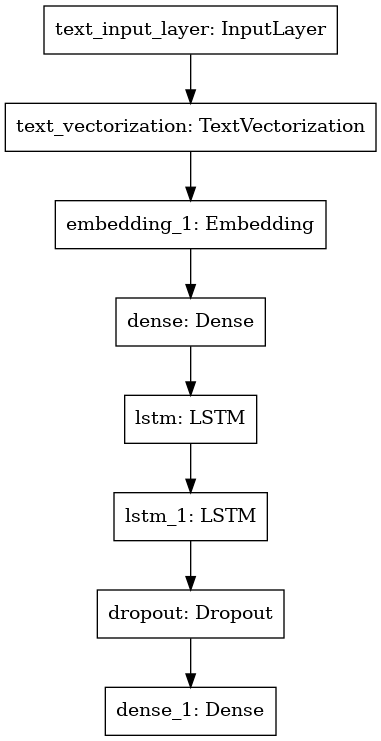

In [28]:
keras.utils.plot_model(model)

In [29]:
X_train = X_train.text
X_valid = X_valid.text
X_test = X_test.text

In [30]:
from keras.callbacks import *

lr = ReduceLROnPlateau(
    monitor="val_auc", mode="max", factor=0.7, patience=4, verbose=False
)
es = EarlyStopping(
    monitor="val_auc", mode="max", patience=10, verbose=False, restore_best_weights=True
)

In [31]:
%%time

history = model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=10,
    # Suppress logging.
    verbose=1,
    callbacks=[es,lr],
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2
)

Epoch 1/10
43/43 [==============================] - 14s 194ms/step - loss: 0.6220 - accuracy: 0.6407 - auc: 0.6854 - val_loss: 0.4844 - val_accuracy: 0.7848 - val_auc: 0.8327
Epoch 2/10
43/43 [==============================] - 7s 173ms/step - loss: 0.3009 - accuracy: 0.8832 - auc: 0.9398 - val_loss: 0.4943 - val_accuracy: 0.7768 - val_auc: 0.8416
Epoch 3/10
43/43 [==============================] - 7s 165ms/step - loss: 0.1282 - accuracy: 0.9562 - auc: 0.9870 - val_loss: 0.5890 - val_accuracy: 0.7739 - val_auc: 0.8319
Epoch 4/10
43/43 [==============================] - 8s 179ms/step - loss: 0.0659 - accuracy: 0.9808 - auc: 0.9954 - val_loss: 0.7736 - val_accuracy: 0.7644 - val_auc: 0.8229
Epoch 5/10
43/43 [==============================] - 7s 167ms/step - loss: 0.0347 - accuracy: 0.9889 - auc: 0.9988 - val_loss: 0.9258 - val_accuracy: 0.7615 - val_auc: 0.8191
Epoch 6/10
43/43 [==============================] - 7s 168ms/step - loss: 0.0195 - accuracy: 0.9951 - auc: 0.9989 - val_loss: 1.0

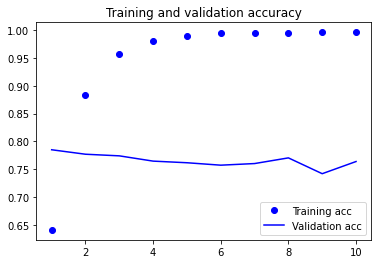

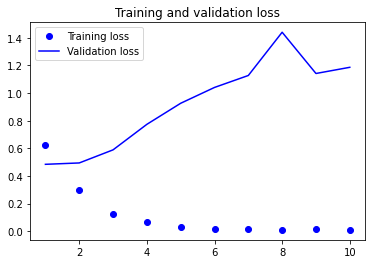

In [32]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

## Predict and Score

In [33]:
test_loss, test_acc, test_auc = model.evaluate(X_valid, y_valid)
test_acc, test_auc

24/24 [==============================] - 1s 21ms/step - loss: 1.1831 - accuracy: 0.7441 - auc: 0.8023


(0.7440944910049438, 0.8022544980049133)

In [34]:
valid_preds = model.predict(X_valid)
valid_preds[:5]

array([[4.9065206e-05],
       [1.7032343e-01],
       [9.7533357e-01],
       [3.2043161e-05],
       [7.2556537e-01]], dtype=float32)

In [35]:
valid_preds[:5]

array([[4.9065206e-05],
       [1.7032343e-01],
       [9.7533357e-01],
       [3.2043161e-05],
       [7.2556537e-01]], dtype=float32)

In [36]:
valid_preds.squeeze()[:10]

array([4.9065206e-05, 1.7032343e-01, 9.7533357e-01, 3.2043161e-05,
       7.2556537e-01, 7.9657167e-02, 1.4904353e-05, 4.3434650e-01,
       7.8378391e-05, 9.9854565e-01], dtype=float32)

In [37]:
valid_preds.ravel()[:10]

array([4.9065206e-05, 1.7032343e-01, 9.7533357e-01, 3.2043161e-05,
       7.2556537e-01, 7.9657167e-02, 1.4904353e-05, 4.3434650e-01,
       7.8378391e-05, 9.9854565e-01], dtype=float32)

In [38]:
valid_preds = np.argmax(valid_preds, axis=1)

In [39]:
# show_scores(y_valid, valid_preds)

In [40]:
preds = model.predict(X_test).ravel()
preds[:5]

array([1.12520866e-04, 1.96825564e-02, 9.99632955e-01, 9.88317013e-01,
       9.99929905e-01], dtype=float32)

In [41]:
preds = (preds > 0.5).astype(int)
np.unique(preds)

array([0, 1])

In [42]:
# preds = np.argmax(preds, axis=1)

## Submission

In [43]:
# Different TARGET name used in test.csv
ss = create_submission("", TARGET, preds)
ss[:5]

,id,target
0,0,0
1,2,0
2,3,1
3,9,1
4,11,1


In [44]:
ss[TARGET].value_counts()

0    1904
1    1359
Name: target, dtype: int64